# Libraries and Google Drive

In [ ]:
pip install owslib rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.1/221.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 24.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from owslib.wms import WebMapService
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from IPython.display import display
from IPython.display import Image as displayImage
import io
import numpy as np
import rasterio
from rasterio.transform import from_bounds
from rasterio.plot import show
import geopandas as gpd
import time
import shapely

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount("/content/drive")

# Import csv of correctly labelled service stations and extract associated polygons

In [ ]:
# Load verified_service_stations csv and transform to list
verified_service_stations_path = '/content/drive/MyDrive/Master Thesis/01 Data Acquisition/verified_service_stations.csv'

# Read the CSV file into a pandas DataFrame
verified_service_stations = pd.read_csv(verified_service_stations_path)

# Transform df to list
verified_service_stations_list = []
for row in verified_service_stations.values.tolist():
    verified_service_stations_list.extend(row)

# Print first 5 items
print("Sample list output:", verified_service_stations[:5])
print("\n")
print("Number of correctly labelled service stations:", len(verified_service_stations_list))

In [ ]:
# Load the GeoJSON files containing service station polygons and truck/car parking polygons together with service station IDs (created in 01a_OSM_rest_stops.ipynb)
all_parkings = gpd.read_file("/content/drive/MyDrive/Master Thesis/01 Data Acquisition/OSM GeoJSON/all_parkings.geojson") # polygons of car and truck parking space
rest_stations = gpd.read_file("/content/drive/MyDrive/Master Thesis/01 Data Acquisition/OSM GeoJSON/rest_stations.geojson") # polygons and ids of rest stations

In [ ]:
# Create geopandas geodataframes that only contain polygons of correctly labelled service stations

print("Shape of all_parkings before dropping irrelevant rows:", all_parkings.shape)
print("Shape of rest_stations before dropping irrelevant rows:", rest_stations.shape)

# Drop all rows not corresponding to correctly labelled service stations
parking_areas_ver = all_parkings[all_parkings["id_rest"].isin(verified_service_stations_list)] # renamed variable!
rest_stations_ver = rest_stations[rest_stations["id"].isin(verified_service_stations_list)]

print("Shape of parking_areas_ver:", parking_areas_ver.shape)
print("Shape of rest_stations after dropping irrelevant rows:", rest_stations_ver.shape)

Shape of all_parkings before dropping irrelevant rows: (1606, 6)
Shape of rest_stations before dropping irrelevant rows: (506, 5)
Shape of parking_areas_ver: (1190, 6)
Shape of rest_stations after dropping irrelevant rows: (267, 5)


In [ ]:
# Drop irrelevant columns, reorder columns, reset index of parkings_areas_ver

parking_areas_ver = parking_areas_ver.drop(["id_car", "name"], axis = 1)
parking_areas_ver = parking_areas_ver.rename(columns={"@id": "id_OSM_parking"})
parking_areas_ver = parking_areas_ver.reindex(columns=["id_rest", "id_OSM_parking", "type", "geometry"])
parking_areas_ver = parking_areas_ver.reset_index(drop = True)

parking_areas_ver.head()

,id_rest,id_OSM_parking,type,geometry
0,lon_7.5846163_lat_53.2588511,way/33526884,car,"POLYGON ((7.58527 53.25883, 7.58618 53.25869, ..."
1,lon_7.2005154_lat_52.2816225,way/38125314,car,"POLYGON ((7.19685 52.28128, 7.19692 52.28127, ..."
2,lon_10.7306355_lat_50.559048,way/48905621,car,"POLYGON ((10.73083 50.55915, 10.73087 50.55881..."
3,lon_10.7298729_lat_50.5605634,way/48925325,car,"POLYGON ((10.72986 50.56033, 10.72980 50.56026..."
4,lon_13.9503161_lat_52.3112817,way/65260801,car,"POLYGON ((13.95364 52.31074, 13.95274 52.31075..."


In [ ]:
# Drop irrelevant columns, reorder columns, reset index of rest_stations_ver

rest_stations_ver = rest_stations_ver.rename(columns={"id": "id_rest", "@id": "id_OSM_rest"})
rest_stations_ver = rest_stations_ver.drop("highway", axis = 1)
rest_stations_ver = rest_stations_ver.reset_index(drop = True)

rest_stations_ver.head()

,id_rest,id_OSM_rest,name,geometry
0,lon_8.6630029_lat_50.2542348,way/22568867,Schäferborn,"POLYGON ((8.66300 50.25423, 8.66302 50.25237, ..."
1,lon_11.3531491_lat_50.9378362,way/27549694,Habichtsfang,"POLYGON ((11.35315 50.93784, 11.35315 50.93783..."
2,lon_9.6300119_lat_53.8303266,way/31128689,Steinburg,"POLYGON ((9.63001 53.83033, 9.63273 53.82905, ..."
3,lon_9.6297338_lat_53.8301666,way/31128716,Steinburg,"POLYGON ((9.62973 53.83017, 9.62965 53.83010, ..."
4,lon_11.0102562_lat_50.8353109,way/32489728,Dornheimer Rieth,"POLYGON ((11.01026 50.83531, 11.01145 50.83591..."


In [ ]:
# Check shapes of dataframes

print("Shape of parking_areas_ver:", parking_areas_ver.shape)
print("Shape of rest_stations after dropping irrelevant rows:", rest_stations_ver.shape)

Shape of parking_areas_ver: (1190, 4)
Shape of rest_stations after dropping irrelevant rows: (267, 4)


In [ ]:
# Download geopandas geodataframes as GeoJSONs

# Specify the path where you want to save the GeoJSON file
output_path_parking_areas_ver = "/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Verified GeoJSON/parking_areas_ver.geojson"
output_path_rest_stations_ver = "/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Verified GeoJSON/rest_stations_ver.geojson"

# Export the GeoPandas DataFrame to GeoJSON
parking_areas_ver.to_file(output_path_parking_areas_ver, driver='GeoJSON')
rest_stations_ver.to_file(output_path_rest_stations_ver, driver='GeoJSON')

# Set up tile services

## WMS and layer information

This code was partly taken from: [OWSLib 0.29.3 documentation -> Examples -> Interact with a WMS](https://owslib.readthedocs.io/en/stable/notebooks/wms.html)

In [ ]:
# Define WMS service and layer to be tested

test_wms_url = "https://geodienste.sachsen.de/wms_geosn_dop-rgb/guest?"
test_layer = "sn_dop_020"

In [ ]:
# Functions to return WMS/ layer information

def get_wms_information(wms_url):
    """
    Output all necessary WMS information for the WMS service provided.

    Parameters:
    wms_url: The GetCapabilities url of the WMS service

    Returns:
    A dictionary with version, url, title, abstract, provider_name, layer_names, operations, operations_urls, format_options
    """

    wms = WebMapService(wms_url, version="1.3.0")

    version = wms.identification.version
    title = wms.identification.title
    abstract = wms.identification.abstract
    provider_name = wms.provider.name
    layer_names = list(wms.contents)
    operations = [op.name for op in wms.operations]
    operations_urls = wms.getOperationByName("GetMap").methods
    format_options = wms.getOperationByName("GetMap").formatOptions

    wms_information = {"version": version,
                       "url": wms_url,
                       "title": title,
                       "abstract": abstract,
                       "provider_name": provider_name,
                       "layer_names": layer_names,
                       "operations": operations,
                       "operations_urls": operations_urls,
                       "format_options": format_options
                       }

    return wms_information

def get_layer_information(wms_url, layer_name):
    """
    Retrieve information about extent and crs_options of selected layer.

    Paramters:
    wms_url: The GetCapabilities url of the WMS service
    layer_name: The name of the selected layer

    Returns:
    A dictionary with layer_name, extent, crs_options.
    """

    wms = WebMapService(wms_url, version="1.3.0")

    extent = wms.contents[layer_name].boundingBoxWGS84
    crs_options = wms[layer_name].crsOptions

    layer_information = {"layer_name": layer_name,
                         "extent": extent,
                         "crs_options": crs_options
                         }

    return layer_information

In [ ]:
# Return all relevant WMS service information
get_wms_information(test_wms_url)

{'version': '1.3.0',
 'url': 'https://geodienste.sachsen.de/wms_geosn_dop-rgb/guest?',
 'title': 'ADV-WMS-DE-SN-DOP-RGB',
 'abstract': 'AdV WMS zur Darstellung der digitalen Orthophotos in Farbe (RGB). DOP sind in die Ebene entzerrte, georeferenzierte Luftbilder. Dabei erfolgt die Projektion der Luftbilder über ein Digitales Geländemodell (DGM) der Erdoberfläche. Seit 2005 werden im Landesamt für Geobasisinformation Sachsen Orthophotos auf Grundlage von Luftbildern aus Bildflügen mit digitalen Kameras erzeugt. Sie besitzen eine Bodenauflösung von 0,20 m.\nWeitere Informationen zum Dienst erhalten Sie im GeoMIS.Sachsen oder über die Metadatenanzeige welche über folgende URL direkt aufrufbar ist: https://geoportal.sachsen.de/cps/metadaten_portal.html?id=26df8686-08cd-4dc2-b459-4d51b9badfe8 Abruf des Dienstestatus GeoBAK2.0-Monitoring über: https://geoportal.sachsen.de/ampel/geodienstestatus?url=https://geodienste.sachsen.de/wms_geosn_dop-rgb/guest?REQUEST=GetCapabilities&SERVICE=WMS (3-o

In [ ]:
# Return all relevant layer information
get_layer_information(test_wms_url, test_layer)

{'layer_name': 'sn_dop_020',
 'extent': (11.788898, 50.150604, 15.08686, 51.72093),
 'crs_options': ['EPSG:3034',
  'EPSG:31465',
  'EPSG:4326',
  'EPSG:25832',
  'EPSG:4258',
  'EPSG:31463',
  'EPSG:3045',
  'EPSG:3044',
  'CRS:84',
  'EPSG:31469',
  'EPSG:3035',
  'EPSG:25833',
  'EPSG:3857',
  'EPSG:31462',
  'EPSG:102100',
  'EPSG:31468',
  'EPSG:31466',
  'EPSG:31464',
  'EPSG:3398',
  'EPSG:3399',
  'EPSG:5514',
  'EPSG:5650',
  'EPSG:31467',
  'EPSG:102067',
  'EPSG:2180']}

## Return image from WMS bbox

### Set-up

In [ ]:
# Define WMS service and layer for each German state

wms_urls = {
        'WMS_NI_DOP': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?Request=GetCapabilities&Service=WMS', # Lower Saxony
        'bebb_dop20c': 'https://isk.geobasis-bb.de/mapproxy/dop20c/service/wms?Request=GetCapabilities&Service=WMS', # Brandenburg & Berlin
        'th_dop': 'https://www.geoproxy.geoportal-th.de/geoproxy/services/DOP?REQUEST=GetCapabilities&version=1.1.1&service=WMS', # Thuringia
        'lsa_lvermgeo_dop20_2': 'https://www.geodatenportal.sachsen-anhalt.de/wss/service/ST_LVermGeo_DOP_WMS_OpenData/guest?', # Saxony-Anhalt
        'he_dop_rgb': 'https://gds-srv.hessen.de/cgi-bin/lika-services/ogc-free-images.ows?', # Hessia
        'sh_dop20_rgb': 'https://dienste.gdi-sh.de/WMS_SH_DOP20col_OpenGBD?Service=wms&version=1.3.0&request=getCapabilities', # Schleswig-Holstein
    }

*   sh_dop20_rgb has an overly large, inaccurate extent. For this reason, this layer is tested last

In [ ]:
# Print WMS and layer information for all selected Länder layers
counter = 1

for layer, url in wms_urls.items():
    print(f"wms_{counter}", get_wms_information(url))
    print(f"layer_{counter}", get_layer_information(url, layer))
    print("\n")
    counter += 1

wms_1 {'version': '1.3.0', 'url': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?Request=GetCapabilities&Service=WMS', 'title': 'WMS NI DOP', 'abstract': 'Digitale Orthophotos Niedersachsen, Bodenauflösung 20 cm (DOP20)', 'provider_name': 'Landesamt für Geoinformation und Landesvermessung Niedersachsen (LGLN) - Landesbetrieb Landesvermessung und Geobasisinformation', 'layer_names': ['WMS_NI_DOP', 'dop20'], 'operations': ['GetCapabilities', 'GetMap', 'GetFeatureInfo'], 'operations_urls': [{'type': 'Get', 'url': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?'}, {'type': 'Post', 'url': 'https://www.geobasisdaten.niedersachsen.de/doorman/noauth/wms_ni_dop?'}], 'format_options': ['image/png', 'image/jpeg', 'image/png; mode=8bit', 'image/vnd.jpeg-png', 'image/vnd.jpeg-png8', 'application/x-pdf', 'image/svg+xml', 'image/tiff', 'application/vnd.google-earth.kml+xml', 'application/vnd.google-earth.kmz', 'application/vnd.mapbox-vector-tile', 'applic

**Findings:**

*   All layers have the option to select the EPSG:4326 coordinate system, a coordinate system on the WGS84 reference ellipsoid
*   WGS84 is also used as the standard coordinates system used by GSP and also OSM
*   Only Niedersachsen, Thüringen and Hessen can export in Tiff format

In [ ]:
def retrieve_layer_extents(wms_urls):
        """
        Retrieve layer extents of the WMS urls.

        Parameters:
        wms_urls (dict): dictionary of layer names and WMS GetCapability URLs

        Returns:
        A dictionary of the extents of the WMS layers.
        """
        wms_layer_extents = {}

        for layer_name, url in wms_urls.items():
            bounding_box = get_layer_information(url, layer_name)["extent"]
            wms_layer_extents[layer_name] = bounding_box

        return wms_layer_extents

In [ ]:
# Extract layer extents
layer_extents = retrieve_layer_extents(wms_urls)
print(layer_extents)

{'WMS_NI_DOP': (6.505772, 51.153098, 11.754046, 54.148101), 'bebb_dop20c': (11.152768795679583, 51.2635170116316, 15.009068839315324, 53.61004915755329), 'th_dop': (9.70043908, 50.13516795, 12.75958006, 51.7188448), 'lsa_lvermgeo_dop20_2': (10.5092, 50.8927, 13.3233, 53.0769), 'he_dop_rgb': (7.41867, 49.25, 10.5, 51.7596), 'sh_dop20_rgb': (0.105946742406, 45.237542736, 20.4488912945, 56.8478734515)}


In [ ]:
def create_png_from_bbox(bbox, wms_urls, layer_extents, size = 2000):
    """
    Create square png map from a bounding box sourced from WMS services.

    Parameters:
    bbox (tuple): (left, bottom, right, top)
    wms_urls (dict): dictionary containing layer_names as keys and urls as values
    layer_extents (dict): dictionary containing layer_names as keys and layer extent tuples as values
    size (int): determines the size of the output png in pixels

    Returns:
    A square png image of the map.
    """


    def bbox_intersects(bbox1, bbox2):
        """
        Check if two bounding boxes intersect.

        Parameters:
        bbox1, bbox2 (tuple): tuple of bbox corners (left, bottom, right, top)

        Returns:
        True if bboxes intersect, False otherwise
        """
        return not (bbox1[2] < bbox2[0] or bbox1[0] > bbox2[2] or
                    bbox1[3] < bbox2[1] or bbox1[1] > bbox2[3])


    def is_blank_image(image):
        """
        Check whether an image is blank or not.

        Parameters:
        image (image object): image of WMS service

        Returns:
        True if image is blank, False otherwise.
        """
        try:
            # Open the image from the image object
            image = Image.open(io.BytesIO(image.read()))

            # Convert the image to a numpy array
            image_array = np.array(image)

            # Depending on the image mode, check whether image is completely white or black
            if image.mode == 'RGB':
                # Check if the image is completely white or black
                is_white = np.all(image_array == [255, 255, 255], axis=(-1)).all()
                is_black = np.all(image_array == [0, 0, 0], axis=(-1)).all()
            elif image.mode == 'RGBA':
                # Check if the image is completely white or black
                is_white = np.all(image_array[:, :, :3] == [255, 255, 255], axis=(-1)).all()
                is_black = np.all(image_array[:, :, :3] == [0, 0, 0], axis=(-1)).all()
            else:
                # Raise error for other image mode
                raise ValueError("Unsupported image mode.")

            return is_white or is_black

        except Exception as e:
            print(f"An error occurred: {e}")
            return False


    def determine_layer_for_bbox(bbox, wms_urls, layer_extents):
        """
        Determine which layer to use based for the provided bounding box.

        Parameters:
        bbox (tuple): bounding box (left, bottom, right, top)
        wms_urls (dict): dictionary containing layer_names as keys and urls as values
        layer_extents: dictionary of layer names and their extent bounding boxes

        Returns:
        Layer name or None if no intersection
        """
        # Check WMSs one after the other until image is returned
        for layer, extent in layer_extents.items():
            wms = WebMapService(wms_urls[layer])
            response = wms.getmap(layers=[layer],
                              srs='EPSG:4326',
                              bbox=square_bbox,
                              size=(2, 2),
                              format='image/png')
            # First, check if bounding box intersects
            if not bbox_intersects(bbox, extent):
                print(f"{layer} does not contain bounding box.")
            # Second, check whether image is blank
            elif is_blank_image(response):
                print(f"{layer} returns blank image.")
            # Return image
            else:
                print(f"{layer} returns image.")

                return layer
        return None


    def encapsulate_in_square_bbox(bbox):
        """
        Create encapsulating, square bounding box.

        Parameters:
        bbox (tuple): bounding box (left, bottom, right, top)

        Returns:
        A square bounding box that encapsulates input bounding box.
        """

        # Extract corners
        lat_min, lon_min, lat_max, lon_max = bbox

        # Calculate the midpoints of the existing bounding box
        mid_lat = (lat_max + lat_min) / 2
        mid_lon = (lon_max + lon_min) / 2

        # Calculate the max spans
        span_lat = (lat_max - lat_min) / 2
        span_lon = (lon_max - lon_min) / 2

        max_span = max(span_lat, span_lon)

        # Calculate new bbox corners
        lat_min_new = mid_lat - max_span
        lat_max_new = mid_lat + max_span
        lon_min_new = mid_lon - max_span
        lon_max_new = mid_lon + max_span

        square_bbox = [lat_min_new, lon_min_new, lat_max_new, lon_max_new]

        return square_bbox


    # Create square bounding box from input bounding box
    square_bbox = encapsulate_in_square_bbox(bbox)

    # Determine the layer that intersects the bounding box
    chosen_layer = determine_layer_for_bbox(square_bbox, wms_urls, layer_extents)

    if chosen_layer == None:
        raise ValueError("No layer intersects with the provided bounding box.")
    else:
        # Correctly create a WebMapService object from chosen layer
        wms = WebMapService(wms_urls[chosen_layer])
        response = wms.getmap(layers=[chosen_layer],
                              srs='EPSG:4326',
                              bbox=square_bbox,
                              size=(size, size),
                              format='image/png')
    # Return the image
    return response

In [ ]:
def pixel_dimensions(image):
    """
    Return pixel dimensions of an image.

    Parameters:
    image (PIL Image object)

    Returns:
    A tuple of width and height dimensions of the input image.
    """

    image_data = BytesIO(image.read())
    image_loaded = Image.open(image_data)

    # Get image dimensions (Width x Height)
    width, height = image_loaded.size

    return (width, height)

### Test image return for test service stations in different states

In [ ]:
# Define test bounding boxes

test_bbox_niedersachsen = [8.42191544, 52.91467249, 8.42508244, 52.91489671]
test_bbox_brandenburg = [13.015424, 52.300345, 13.020988, 52.302384]
test_bbox_thüringen = [11.196242, 50.947367, 11.200492, 50.948778]
test_bbox_sh = [9.939001, 53.717082, 9.939979, 53.720104]
test_bbox_hessen = [8.350782, 50.094450, 8.354213, 50.099812]
test_bbox_fail = [8.4231, 48.375354, 8.4421, 48.385273] # bbox not within covered area, should return error message
test_bbox_magdeburg = [11.448439, 52.183663, 11.455710, 52.186811] # magdeburg convered by several extents, but should return image from lsa layer

In [ ]:
# Test create_png_from_bbox function
try:
    # Input bbox to be tested
    response = create_png_from_bbox(test_bbox_magdeburg, wms_urls, layer_extents, size = 1000)
    # Further code to handle the response
except ValueError as e:
    print(e)

WMS_NI_DOP returns blank image.
bebb_dop20c returns blank image.
th_dop does not contain bounding box.
lsa_lvermgeo_dop20_2 returns image.


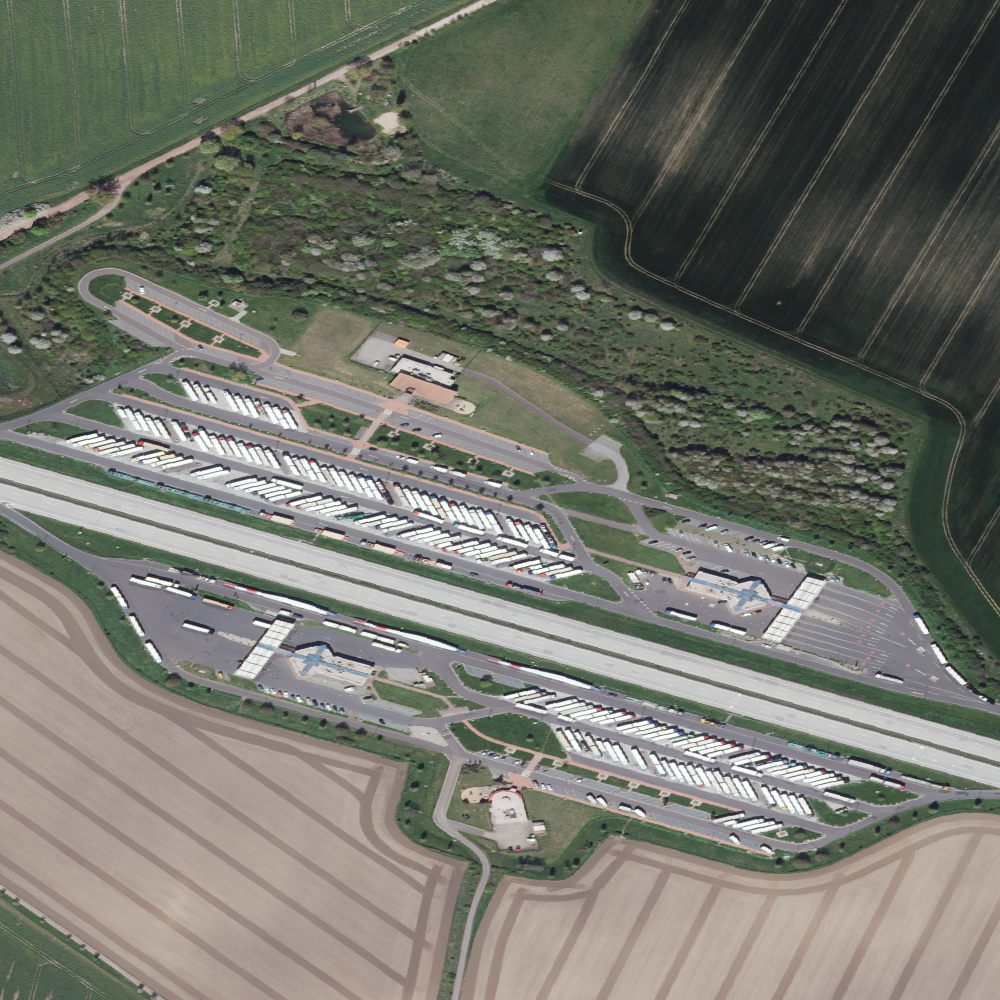

In [ ]:
# Display returned image

displayImage(response.read())

In [ ]:
print("Image pixel dimensions", pixel_dimensions(response))

Image pixel dimensions (1000, 1000)


# Load GeoJSONs and show sample polygons

In [ ]:
# Load the GeoJSON files of verified rest stops
parking_areas_ver = gpd.read_file("/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Verified GeoJSON/parking_areas_ver.geojson") # polygons of verified car and truck parking space
rest_stations_ver = gpd.read_file("/content/drive/MyDrive/Master Thesis/01 Data Acquisition/Verified GeoJSON/rest_stations_ver.geojson") # polygons of verified rest stops

## Find biggest service station

In [ ]:
def biggest_rest_station(geodataframe):
    """
    Returns the biggest rest station.

    Parameters:
    geodataframe (geopandas geodataframe): contains polygon/multipolygon geometries

    Returns:
    The bounding box of the biggest rest station.
    """

    def polygon_to_bbox(polygon):
        """
        Transforms a polygon into a square bounding box.

        Parameters:
        polygon (Polygon): input polygon

        Returns:
        The resulting square bounding box bounds as a list: [left, bottom, right, top].
        """

        # Calculate the bounding box of the polygon
        minx, miny, maxx, maxy = polygon.bounds
        bbox = [minx, miny, maxx, maxy]

        return bbox

    # Initialize variables
    max_span_overall = 0
    biggest_rest_station = None
    biggest_rest_station_bbox = None
    biggest_rest_station_name = None


    # Loop over all rows in the df, calculate the bbox and find the largest span
    for index, row in geodataframe.iterrows():
        bbox = polygon_to_bbox(row["geometry"])
        minx, miny, maxx, maxy = bbox
        x_span = maxx - minx
        y_span = maxy - miny

        max_span = max(x_span, y_span)

        if max_span > max_span_overall:
            max_span_overall = max_span
            biggest_rest_station = row["id"]
            biggest_rest_station_bbox = [minx, miny, maxx, maxy]
            biggest_rest_station_name = row["name"]

    print(f"The biggest rest station is {biggest_rest_station_name} (id: {biggest_rest_station}) with a maximum bounding box span of {max_span_overall}")

    return biggest_rest_station_bbox

In [ ]:
biggest_rest_station_bbox = biggest_rest_station(rest_stations)

The biggest rest station is Neu-Nordsee (id: lon_9.9181171_lat_54.315654) with a maximum bounding box span of 0.008475900000000536


In [ ]:
response = create_png_from_bbox(biggest_rest_station_bbox, wms_urls, layer_extents, size = 100)

WMS_NI_DOP does not contain bounding box.
bebb_dop20c does not contain bounding box.
th_dop does not contain bounding box.
lsa_lvermgeo_dop20_2 does not contain bounding box.
he_dop_rgb does not contain bounding box.
sh_dop20_rgb returns image.


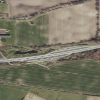

In [ ]:
displayImage(response.read())

In [ ]:
print("Image pixel dimensions", pixel_dimensions(response))

Image pixel dimensions (100, 100)


# Graveyard

In [ ]:
rest_stations_correct = []
for index, row in rest_stations.iterrows():
    if row["id"] in verified_service_stations_list:
        verified_service_stations.append(row)

rest_stations_correct = pd.DataFrame(verified_service_stations)
rest_stations_correct = verified_service_stations.reset_index()

<ipython-input-82-e97591e333be>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  verified_service_stations.append(row)
<ipython-input-82-e97591e333be>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  verified_service_stations.append(row)
<ipython-input-82-e97591e333be>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  verified_service_stations.append(row)
<ipython-input-82-e97591e333be>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  verified_service_stations.append(row)
<ipython-input-82-e97591e333be>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [ ]:
all_parkings.head()

,id_car,@id,name,id_rest,type,geometry
0,relation/13277622,relation/13277622,None,lon_10.2703215_lat_53.3301407,car,"MULTIPOLYGON (((10.26903 53.33039, 10.26926 53..."
1,relation/13277623,relation/13277623,None,lon_10.2712414_lat_53.331074,car,"MULTIPOLYGON (((10.26848 53.33228, 10.26872 53..."
2,relation/15482166,relation/15482166,None,lon_12.140788_lat_52.2431929,car,"MULTIPOLYGON (((12.14216 52.24271, 12.14213 52..."
3,relation/15482306,relation/15482306,None,lon_12.149456_lat_52.2449316,car,"MULTIPOLYGON (((12.14713 52.24497, 12.14717 52..."
4,way/31129920,way/31129920,Nord-Ostsee-Kanal,lon_9.323161_lat_54.0686721,car,"POLYGON ((9.32127 54.06898, 9.32314 54.06861, ..."


In [ ]:
all_parkings_correct = []
for index, row in all_parkings.iterrows():
    if row["id_rest"] in verified_service_stations_list:
        all_parkings_correct.append(row)

all_parkings_correct = pd.DataFrame(all_parkings_correct)
all_parkings_correct = all_parkings_correct.reset_index()

In [ ]:
all_parkings_correct

,index,id_car,@id,name,id_rest,type,geometry
0,5,way/33526884,way/33526884,Rastplatz Brinkum,lon_7.5846163_lat_53.2588511,car,"POLYGON ((7.5852698 53.2588255, 7.5861797 53.2..."
1,6,way/38125314,way/38125314,None,lon_7.2005154_lat_52.2816225,car,"POLYGON ((7.1968549 52.2812781, 7.1969165 52.2..."
2,9,way/48905621,way/48905621,None,lon_10.7306355_lat_50.559048,car,"POLYGON ((10.7308295 50.5591504, 10.7308651 50..."
3,10,way/48925325,way/48925325,None,lon_10.7298729_lat_50.5605634,car,"POLYGON ((10.7298595 50.5603334, 10.7297952 50..."
4,11,way/65260801,way/65260801,None,lon_13.9503161_lat_52.3112817,car,"POLYGON ((13.9536429 52.3107417, 13.9527447 52..."
...,...,...,...,...,...,...,...
1185,1601,None,way/1194289084,None,lon_11.0467665_lat_51.4688222,truck,"POLYGON ((11.0438038 51.4678761, 11.0441384 51..."
1186,1602,None,way/1194289085,None,lon_11.0467665_lat_51.4688222,truck,"POLYGON ((11.0443887 51.4681512, 11.0444483 51..."
1187,1603,None,way/1194289086,None,lon_11.0467665_lat_51.4688222,truck,"POLYGON ((11.045028 51.468464, 11.0450594 51.4..."
1188,1604,None,way/1194289087,None,lon_11.0467665_lat_51.4688222,truck,"POLYGON ((11.043748 51.467577, 11.0439927 51.4..."


In [ ]:
rest_stations_correct

NameError: name 'rest_stations_correct' is not defined

In [ ]:
def show_correct_service_station(index):

    service_station = rest_stations_correct.iloc[index,0]

            coord = create_coord(row[-1])

            # Store the map in a variable
            folium_map = create_folium_map(coord, service_stations=rest_stations_correct, parking=all_parkings_correct)

            # Clear the previous output and display the new map
            display(folium_map)



            coord = create_coord(row[-1])
    name = row["name"]
    id = row["id"]

    # Store the map in a variable
    folium_map = create_folium_map(coord, service_stations=rest_stations, parking=all_parkings)

In [ ]:
m = show_correct_service_station(2)
display(m)

None

In [ ]:
all_parkings.head()

,id_car,@id,name,id_rest,type,geometry
0,relation/13277622,relation/13277622,None,lon_10.2703215_lat_53.3301407,car,"MULTIPOLYGON (((10.26903 53.33039, 10.26926 53..."
1,relation/13277623,relation/13277623,None,lon_10.2712414_lat_53.331074,car,"MULTIPOLYGON (((10.26848 53.33228, 10.26872 53..."
2,relation/15482166,relation/15482166,None,lon_12.140788_lat_52.2431929,car,"MULTIPOLYGON (((12.14216 52.24271, 12.14213 52..."
3,relation/15482306,relation/15482306,None,lon_12.149456_lat_52.2449316,car,"MULTIPOLYGON (((12.14713 52.24497, 12.14717 52..."
4,way/31129920,way/31129920,Nord-Ostsee-Kanal,lon_9.323161_lat_54.0686721,car,"POLYGON ((9.32127 54.06898, 9.32314 54.06861, ..."
